In [1]:
import os
from tqdm import tqdm
from io import BytesIO
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard.writer import SummaryWriter
import torch
from model import GVAE
from loss import reconstruction_loss, kl_loss
from dataset import SketchDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
os.chdir('../')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = SketchDataset(root="data/")

generator = torch.Generator().manual_seed(4)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.033, 0.067], generator = generator)

print("Number of Graphs in total: ", dataset.len())
print("Number of Graphs for training: ", len(train_set))
print("Number of Graphs for validation: ", len(validate_set))
print("Number of Graphs for testing: ", len(test_set))

Number of Graphs in total:  150
Number of Graphs for training:  136
Number of Graphs for validation:  4
Number of Graphs for testing:  10


In [3]:
batch_size = 64
learning_rate = 1e-2
num_epochs = 10

In [4]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
validate_loader = DataLoader(dataset = validate_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

model = GVAE(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

writer = SummaryWriter('runs/gvae_experiment_1')

In [5]:
def figure_to_tensor(figure):
    """
    Convert a Matplotlib figure to a PyTorch tensor.

    :param figure: Matplotlib figure to convert.
    :return: PyTorch tensor.
    """
    # Convert the Matplotlib figure to a NumPy array
    buf = BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    image = plt.imread(buf)

    # Convert the NumPy array to a PyTorch tensor
    transform = transforms.ToTensor()
    tensor = transform(image)

    return tensor

In [7]:
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    # Train Model for one epoch
    print(f"Epoch {epoch} Training model ---")
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_idx, (nodes, edges, node_params_mask) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        target_nodes = nodes.to(device)
        target_edges = edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)
        
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

        # Log training loss every 1000 mini-batches
        if batch_idx % 1 == 0 and batch_idx > 0:
            avg_train_loss = total_train_loss / num_train_batches  # Calculate average up to the current batch
            writer.add_scalar("Training Loss", avg_train_loss, epoch * len(train_loader) + batch_idx)
    
    # Validate Model at end of epoch
    print(f"Epoch {epoch} Validating model ---")
    model.eval()
    total_validate_loss = 0.0
    num_validate_batches = 0
    for batch_idx, (nodes, edges, node_params_mask) in enumerate(tqdm(validate_loader)):
        target_nodes = nodes.to(device)
        target_edges = edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

        total_validate_loss += loss.item()
        num_validate_batches += 1
    
    # Calculate and log the average validation loss for this epoch
    avg_validate_loss = total_validate_loss / num_validate_batches  # Calculate average up to the last batch
    writer.add_scalar("Validation Loss", avg_validate_loss, epoch)

    # Save the model checkpoint if the validation loss improves
    if avg_validate_loss < best_validation_loss:
        best_validation_loss = avg_validate_loss
        checkpoint_path = f"best_model_checkpoint.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint with validation loss: {best_validation_loss:.4f} to {checkpoint_path}")


Epoch 0 Training model ---


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 0 Validating model ---


100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


Saved model checkpoint with validation loss: 1.7551 to best_model_checkpoint.pth
Epoch 1 Training model ---


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 1 Validating model ---


100%|██████████| 1/1 [00:00<00:00, 26.12it/s]


Saved model checkpoint with validation loss: 1.7241 to best_model_checkpoint.pth
Epoch 2 Training model ---


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 2 Validating model ---


100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


Saved model checkpoint with validation loss: 1.5884 to best_model_checkpoint.pth
Epoch 3 Training model ---


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch 3 Validating model ---


100%|██████████| 1/1 [00:00<00:00, 30.55it/s]


Saved model checkpoint with validation loss: 1.5718 to best_model_checkpoint.pth


In [ ]:

# Test Model
print(f"Testing model ---")
model.eval()
for batch_idx, (nodes, edges, node_params_mask) in enumerate(tqdm(test_loader)):
    target_nodes = nodes.to(device)
    target_edges = edges.to(device)
    node_params_mask = node_params_mask.to(device)

    pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)
    
    loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

torch.Size([24, 20])
torch.Size([24, 24, 17])
Sketch(n_entities=6, n_constraints=0)


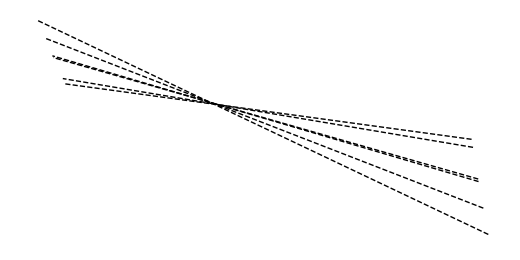

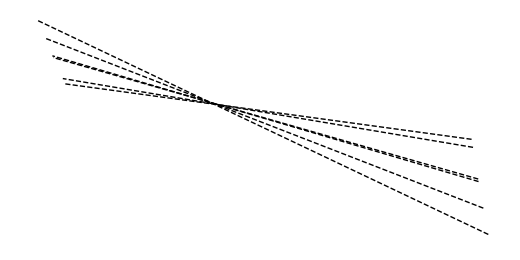

In [36]:
# model = GVAE(device)
# dataset = SketchDataset(root="data/")
# dataset.len()

# nodes, edges, node_params_mask = dataset[0]


# s2 = dataset.preds_to_sketch(nodes, edges)

# datalib.render_sketch(s2)

# print(s2)

# # batch_size = 64
# # dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
# # learning_rate = 1e-2
# # epochs = 4
# # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# # model.train()
# # for batch, (nodes, edges, node_params_mask) in enumerate(dataloader):
# #     optimizer.zero_grad()
    
# #     target_nodes = nodes.to(device)
# #     target_edges = edges.to(device)
# #     node_params_mask = node_params_mask.to(device)

# #     pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

# #     loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

# #     loss.backward()
# #     optimizer.step()

# #     print(f"loss: {loss.item()}")


model.eval()
nodes, edges = model.sample_graph()
print(nodes.shape)
print(edges.shape)
sketch = SketchDataset.preds_to_sketch(nodes.cpu(), edges.cpu())
print(sketch)
datalib.render_sketch(sketch)